# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use model selection for performing some simple analysis on real neural signals. 

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders
* Select the optimal model via cross-validation

The last stage of the lab uses LASSO estimation for model selection.  If you are doing this part of the lab, you should review the concepts in [LASSO demonstration](./prostate.ipynb) on the prostate cancer  dataset.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the basic packages.

In [138]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [139]:
import scipy.io
mat_dict = scipy.io.loadmat("StevensonV2.mat")

The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [140]:
#TODO
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

We extract two variables, `spikes` and `handVel`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand velocity.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handVel` data, we take the first component which is the motion in the $x$-direction.

In [141]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handVel'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [142]:
# TODO 
X0.shape
nt = X0.shape[0]
nneuron=X0.shape[1]
print('nt = '+str(X0.shape[0]))
print('nneuron = '+str(X0.shape[1]))

nt = 15536
nneuron = 196


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [143]:
# TODO
time = mat_dict['time']
time.reshape(1,nt)
print('tsamp = ' +str(time[0][1]-time[0][0]))
l = len(time[0])
print('Number of samples: ' +str(l))
print('ttotal = ' + str(time[0][l-1] - time[0][0]))

tsamp = 0.05
Number of samples: 15536
ttotal = 776.75


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [144]:
# TODO

Xtr = X0[0:(15536//2),:]
ytr = y0[0:(15536//2)]
Xts = X0[(15536//2):,:]
yts = y0[(15536//2):]

Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [149]:
import sklearn.linear_model

regr = sklearn.linear_model.LinearRegression()
regr.fit(Xtr,ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Measure and print the normalized RSS on the test data.  

In [150]:
# TODO
vel_pred_ts = regr.predict(Xts)
n = len(time[0]) #number of training examples
var_ts = np.var(yts)
RSS_test = np.mean((vel_pred_ts-yts)**2)/var_ts
print('Normalized RSS on the test data= '+str(RSS_test))
#print(vel_pred_ts)

Normalized RSS on the test data= 1.88937984291e+21


You should see that the test error is enormous -- the model does not generalize to the test data at all. 

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

0.00304952956781
196
(7768, 196)


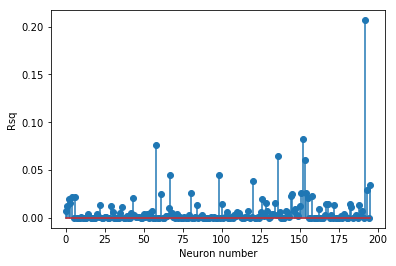

In [151]:
# TODO
ytr_var = np.var(ytr)
print(ytr_var)
#The preicted values taking one neuron at a time 
pred_mat= []
neurons = Xtr.shape[1]
print(neurons)
#print(Xtr[0:5,:])
#print(Xtr[0:5,0])
#trial = Xtr[0:5,0]
#trial.reshape(-1,1)

for i in range(0,neurons):
    tempo= Xtr[:,i].reshape(-1,1)
    regr.fit(tempo,ytr) #training with each neuron 
    pred_mat.append(regr.predict(tempo)) #prediction for each neuron 

intermediate = np.array(pred_mat).T #an array 7768x196 containing predicted values for each time bin for each neuron 
print(intermediate.shape)
intermediate_rss= ((intermediate - ytr.reshape(7768,1))**2)
intermediate_rss_mean = (np.sum(intermediate_rss,axis=0)/7768)/ytr_var
Rsq = np.array(1 - intermediate_rss_mean)
#print(Rsq)
#print(ytr.shape)
#print(intermediate[0:5,:])
#print(len(intermediate[0]))
plt.stem(range(0,neurons),Rsq)
plt.xlabel('Neuron number')
plt.ylabel('Rsq')
plt.show()

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=100` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [152]:
d = 100  # Number of neurons to use

# TODO
np.argsort(Rsq)
neu_sel = Rsq.argsort()[-100:][::-1]
neu_all = Rsq.argsort()[:][::-1]
#print(neu_sel)
#print(neu_all)

print("The neurons with the ten highest R^2 values =" , Rsq.argsort()[-10:][::-1] )

The neurons with the ten highest R^2 values = [192 152  58 136 153  67  98 120 195 193]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [153]:
# TODO
#new training set 
import pandas as pd
Xtr_int = pd.DataFrame(Xtr)
Xtr_int.head(6)
Xts_int = pd.DataFrame(Xts)

Xtr_new = Xtr_int[[num for num in neu_sel]] #new selected training features 
Xts_new = Xts_int[[num for num in neu_sel]] #new selected testing features
regr.fit(Xtr_new,ytr)
ypred_new_test = regr.predict(Xts_new)

RSS_per_sample = np.mean((yts-ypred_new_test)**2)
RSS_test_new = RSS_per_sample/np.var(yts)
print('RSS per sample = ',RSS_per_sample)
print('Normalized test RSS =', RSS_test_new)

RSS per sample =  0.00162913416395
Normalized test RSS = 0.514132924996


Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

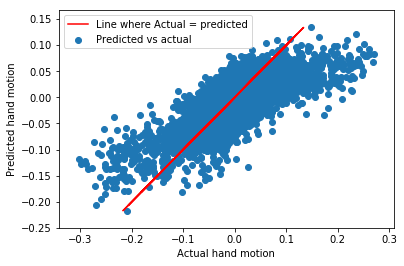

In [154]:
# TODO

plt.scatter(yts,ypred_new_test)


plt.plot(ypred_new_test,ypred_new_test,'r')
plt.xlabel('Actual hand motion')
plt.ylabel('Predicted hand motion')
plt.legend(['Line where Actual = predicted','Predicted vs actual'])
plt.plot()
plt.show()

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=100`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [155]:
#modifying the original array so that the neuron columns appear in decreasing orfer of R^2
#when d= n , the neurons with the highest n R^s are chosen for training in the kfold cross validation
#new array stored in X0_arranged

X0_arranged = pd.DataFrame(X0)
X0_arranged.head(6)
cols = X0_arranged.columns.tolist()
cols = neu_all
print('Indices in descending order of R^2: \n')
print(cols)
X0_arranged =X0_arranged[cols]
print('\n\nShowing the first 6 rows in the modified dataset...')
#print(X0_arranged.iloc[0:1,0:10])
X0_arranged.head(6)

#
#kfoldset = X0_arranged.as_matrix(columns=None)

#print(X0_kfold[0:5,:])
#print(kfoldset[0:5,:])


Indices in descending order of R^2: 

[192 152  58 136 153  67  98 120 195 193 151  80 154 145  61 158 144   4
   6 155  43   2 126 134 128   3 168 167 182 100 188 172  84  22  29 150
   1  36 183  66 147 162 129   0  55 146 117 141 190 142 103 110  30 137
 125  54 111  68  42  35 178  50  14  71  20 133  52 132  87 135 166  79
 170  44 108 148 186 179 127 189 109  39 149  65 176  64 106  45  25  93
  26  46 102 131 115  73 143 185  69 112  95  15  47  10  51 116  21  83
 123 119  86  76 118 124 138 160  60  59  18  16  57 169 107 156   8 187
 140  11  17 114  49 194  12 159 165 175 180   5  48 130  91 121  90  75
  34  40 173 104  97  23  89  99 101  85 161  88 164 191  78  96  27  28
   7 157  81  92  77  19  38  63 171  32  33  74  70 113 181   9  56 174
  72 184  94  31 163  62  37  53  24  82 105 122  13 177 139  41]


Showing the first 6 rows in the modified dataset...


,192,152,58,136,153,67,98,120,195,193,...,37,53,24,82,105,122,13,177,139,41
0,0,1,1,3,6,0,9,3,2,2,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,4,4,0,7,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,5,4,0,7,3,3,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,7,2,0,7,4,2,1,...,0,0,0,0,0,0,0,0,0,0
4,0,2,1,4,4,1,8,8,3,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,1,4,3,2,8,4,3,0,...,0,0,0,0,0,0,0,0,0,0


# 10-fold validation was done for model numbers ranging from 10 to 190 in steps of 10. The error was seen to decrease with increase in model number up to 190. 


#code FOR d RANGING FROM 10 TO 190

In [178]:
import  sklearn.model_selection 

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)
print(nd)

#Modified dataset for K-fold 
X0_kfold = np.array(X0_arranged)


RSSts = np.zeros((nd,nfold))
#print(RSSts)
for isplit, Ind in enumerate(kf.split(X0_kfold)):
    Itr,Its = Ind
    xtra = X0_kfold[Itr]
    ytra = y0[Itr]
    xtes = X0_kfold[Its]
    ytes = y0[Its]
    
    for it,d in enumerate(dtest):
        xtraa = pd.DataFrame(xtra) 
        xtraaa = xtraa.iloc[:,0:d] #chooses the first d columns of the dataframe (which is in decreasing order of
                                   # R^2) in each iteration of model order 
        clf = sklearn.linear_model.LinearRegression()
        clf.fit(xtraaa,ytra)
        
        xtess = pd.DataFrame(xtes)
        xtesss = xtess.iloc[:,0:d]
        p = clf.predict(xtesss)
        RSSts[it,isplit]= np.mean((p-ytes)**2)
        #print(d)

print(RSSts)

19
[[ 0.00192091  0.00198375  0.00179466  0.00173357  0.00190124  0.00178392
   0.00190113  0.00192817  0.00189789  0.00183265]
 [ 0.00180135  0.00181668  0.0016316   0.00158993  0.00170722  0.00170556
   0.00180023  0.00176051  0.00171596  0.0017203 ]
 [ 0.00177173  0.00176931  0.00158664  0.00156714  0.00169916  0.00169686
   0.00177318  0.0017417   0.00169635  0.00169754]
 [ 0.00173167  0.00169173  0.0015448   0.0015336   0.00169958  0.00165419
   0.00172178  0.0016945   0.00164385  0.00163777]
 [ 0.0016997   0.00168048  0.00153511  0.00150622  0.00167411  0.00164166
   0.00170755  0.00169494  0.00162432  0.00160124]
 [ 0.00166397  0.00165893  0.00151887  0.0014647   0.00163835  0.00162671
   0.00168737  0.00167453  0.0015773   0.00154749]
 [ 0.00164823  0.00164881  0.00151026  0.00144823  0.00162169  0.00160939
   0.00167856  0.00166104  0.00157441  0.00153206]
 [ 0.0016213   0.00164317  0.00147103  0.00140702  0.00158627  0.00157564
   0.00164638  0.00162905  0.00157991  0.0015141

Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method. 

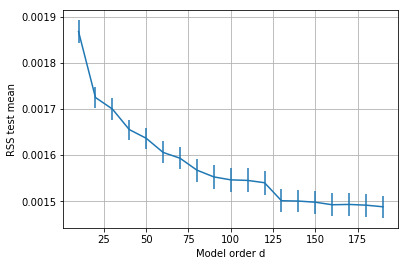

Number of models:  19
Minimum RSS:  0.00148791918372
Maximim RSS:  0.00186778861121


In [179]:
# TODO
rss_test_mean = np.mean(RSSts,axis=1)
rss_std_err = np.std(RSSts,axis=1)/np.sqrt(nfold-1)
plt.errorbar(dtest,rss_test_mean,yerr=rss_std_err,fmt='-')
plt.xlabel('Model order d')
plt.ylabel('RSS test mean')
plt.grid()
plt.show()
print('Number of models: ' ,len(rss_test_mean))
print('Minimum RSS: ', min(rss_test_mean))
print('Maximim RSS: ',max(rss_test_mean))

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [180]:
# TODO
mini = np.argmin(rss_test_mean)
msee_tgt = rss_test_mean[mini]+rss_std_err[mini]
d_min= dtest[mini]

I=np.where(rss_test_mean< msee_tgt)[0]
opti = I[-1]
d_opt = dtest[opti]
print('Optimum model d: ',d_opt)
#d=190 is the 19th observation in rss_test_mean
print('Mean RSS per sample at optimal d = 190: ',rss_test_mean[18])

Optimum model d:  190
Mean RSS per sample at optimal d = 190:  0.00148791918372


## Using LASSO regression

Instead of using the above heuristic to select the variables, we can use LASSO regression.  

First use the `preprocessing.scale` method to standardize the data matrix `X0`.  Store the standardized values in `Xs`.  You do not need to standardize the response.  For this data, the `scale` routine may throw a warning that you are converting data types.  That is fine.

In [134]:
from sklearn import preprocessing
#print (X0)
X = preprocessing.scale(X0, axis=0, with_mean=True, with_std=True, copy=True)
#print(X)

C:\Users\Suhaila Shakiah\Anaconda2\envs\py3k\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now, use the LASSO method to fit a model.  Use cross validation to select the regularization level `alpha`.  Use `alpha` values logarithmically spaced from `1e-5` to `0.1`, and use 10 fold cross validation.  

In [112]:
# TODO
from sklearn import linear_model 
nfold = 10
kf1 = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

model = linear_model.Lasso(warm_start= True)
nalpha= 100
alphas = np.logspace(-5,-1,nalpha)

mse = np.zeros((nalpha,nfold))
for ifold ,ind in enumerate(kf1.split(X)):
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y0[Itr]
    X_ts = X[Its,:]
    y_ts = y0[Its]
    
    for ia,a  in enumerate(alphas):
        
        model.alpha = a
        model.fit(X_tr,y_tr)
        
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred - y_ts)**2)
        
print(mse)

[[ 0.00156068  0.00157143  0.00161853  0.00135799  0.00154159  0.00138665
   0.00156184  0.00150087  0.00130708  0.00147719]
 [ 0.00156066  0.0015714   0.00161855  0.00135794  0.00154156  0.00138656
   0.00156182  0.00150081  0.00130704  0.00147713]
 [ 0.00156065  0.00157138  0.00161856  0.00135788  0.00154152  0.00138647
   0.0015618   0.00150073  0.001307    0.00147708]
 [ 0.00156064  0.00157134  0.00161858  0.00135782  0.00154148  0.00138637
   0.00156177  0.00150065  0.00130696  0.00147701]
 [ 0.00156062  0.00157131  0.0016186   0.00135775  0.00154144  0.00138626
   0.00156175  0.00150057  0.00130691  0.00147695]
 [ 0.00156061  0.00157127  0.00161862  0.00135767  0.00154139  0.00138613
   0.00156172  0.00150048  0.00130687  0.00147687]
 [ 0.0015606   0.00157123  0.00161864  0.00135759  0.00154134  0.001386
   0.0015617   0.00150039  0.00130681  0.0014768 ]
 [ 0.00156057  0.00157118  0.00161867  0.00135751  0.00154127  0.00138586
   0.00156167  0.00150028  0.00130676  0.00147672]
 [

Plot the mean test RSS and test RSS standard error with the `plt.errorbar` plot.

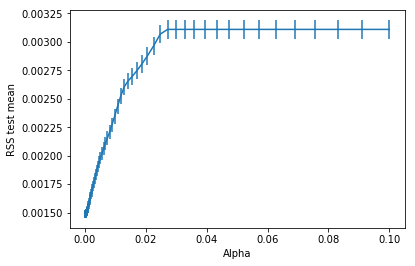

Number of models:  100
Minimum RSS:  0.00148620096899
Maximim RSS:  0.0031095429329


In [181]:
# TODO
rtm = np.mean(mse,axis=1)
rse = np.std(mse,axis=1)/np.sqrt(nfold-1)
plt.errorbar(alphas,rtm,yerr=rse,fmt='-')
plt.xlabel('Alpha')
plt.ylabel('RSS test mean')
plt.show()
print('Number of models: ' ,len(rtm))
print('Minimum RSS: ', min(rtm))
print('Maximim RSS: ',max(rtm))

Find the optimal `alpha` and mean test RSS using the one standard error rule.

In [136]:
# TODO
imin = np.argmin(rtm)
mse_tgt = rtm[imin]+rse[imin]
alph_min = alphas[imin]

I=np.where(rtm<mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print('Optimum alpha: ',alpha_opt)

Optimum alpha:  0.000722080901839


Using the optimal alpha, recompute the predicted response variable on the whole data.  Plot the predicted vs. actual values.

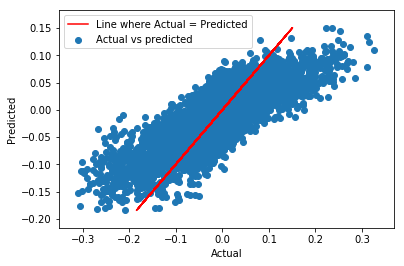

In [137]:
# TODO
remodel = linear_model.Lasso(warm_start= True)
remodel.alpha = alpha_opt
remodel.fit(X,y0)
y_ts_pred = remodel.predict(X)
        #mse[ia,ifold] = np.mean((y_ts_pred - y0)**2)
plt.scatter(y0,y_ts_pred)
plt.plot(y_ts_pred,y_ts_pred,'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend([ 'Line where Actual = Predicted', 'Actual vs predicted'])

plt.show()

## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.

In [ ]:
pwd